In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
import pickle
import tensorflow as tf
import cv2
import keras.backend as K

/packages/7x/anaconda3/5.3.0/envs/tf2.4.1-gpu/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2022-12-02 18:20:53.292569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 18:20:53.970227: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-02 18:20:54.255685

In [2]:
%pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/sgupt279/.local/lib/python3.8/site-packages (1.1.3)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# params we will probably want to do some hyperparameter optimization later
BASE_MODEL= 'VGG16' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (384, 384) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 24 # [1, 8, 16, 24]
DENSE_COUNT = 128 # [32, 64, 128, 256]
DROPOUT = 0.25 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 8000 # [3000, 6000, 15000]
TEST_SAMPLES = 800
USE_ATTN = False # [True, False]

In [4]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='NASNetLarge':
    from keras.applications.nasnet import NASNetLarge as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [5]:
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)

In [6]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set_HUMERUS.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set_HUMERUS.csv", dtype=str)
train_df

,Train_Image,Train_Label
0,MURA-v1.1/train/XR_HUMERUS/patient02695/study1...,1
1,MURA-v1.1/train/XR_HUMERUS/patient02626/study1...,1
2,MURA-v1.1/train/XR_HUMERUS/patient02626/study1...,1
3,MURA-v1.1/train/XR_HUMERUS/patient02696/study1...,1
4,MURA-v1.1/train/XR_HUMERUS/patient02696/study1...,1
...,...,...
1267,MURA-v1.1/train/XR_HUMERUS/patient03224/study1...,0
1268,MURA-v1.1/train/XR_HUMERUS/patient03225/study1...,0
1269,MURA-v1.1/train/XR_HUMERUS/patient03225/study1...,0
1270,MURA-v1.1/train/XR_HUMERUS/patient03226/study1...,0


In [7]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set_ELBOW.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set_ELBOW.csv", dtype=str)

In [8]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set_SHOULDER.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set_SHOULDER.csv", dtype=str)

In [9]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set_HAND.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set_HAND.csv", dtype=str)

In [10]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set_FINGER.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set_FINGER.csv", dtype=str)

In [11]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set_FOREARM.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set_FOREARM.csv", dtype=str)

In [12]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set_WRIST.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set_WRIST.csv", dtype=str)

In [7]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 


In [8]:


# Image Preprocessing
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=None,
                                              x_col="Train_Image", y_col="Train_Label",
                                              target_size=(224,224), class_mode="categorical",
                                              batch_size=BATCH_SIZE, shuffle=True)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=valid_df, directory=None,
                                              x_col="Valid_Image", y_col="Valid_Label",
                                              target_size=(224,224), class_mode="categorical",
                                              batch_size=BATCH_SIZE, shuffle=True)

Found 1272 validated image filenames belonging to 2 classes.
Found 288 validated image filenames belonging to 2 classes.


(24, 224, 224, 3) (24, 2)


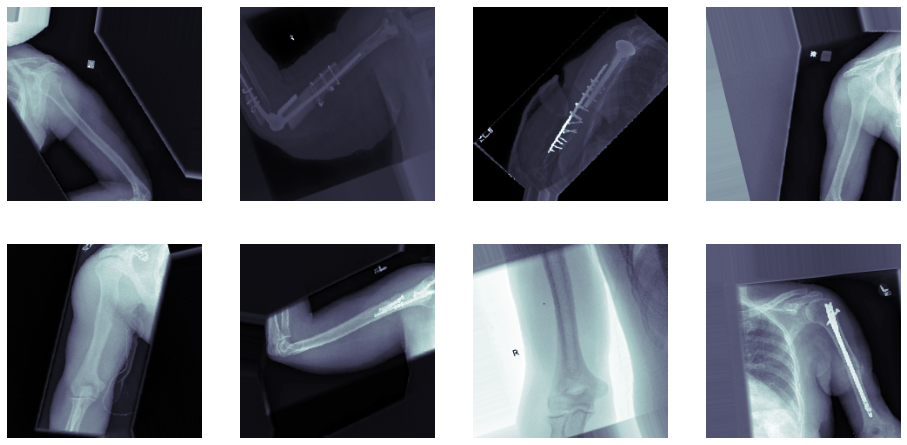

In [9]:
t_x, t_y = next(train_generator)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    #c_ax.set_title('%s' % class_enc.classes_[np.argmax(c_y)])
    c_ax.axis('off')

In [10]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

2022-12-02 18:21:18.554131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sgupt279/.local/lib/python3.8/site-packages/cv2/../../lib64:/packages/7x/anaconda3/5.3.0/lib
2022-12-02 18:21:18.554189: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-02 18:21:18.555299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI F

In [11]:
t_x.shape[1:]

(224, 224, 3)

In [12]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.optimizers import Adam
from keras import layers
in_lay = Input(t_x.shape[1:])
pt_features = base_pretrained_model(in_lay)
#pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
gap = GlobalAveragePooling2D()(bn_features)

gap_dr = Dropout(DROPOUT)(gap)
dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
dr_steps = BatchNormalization()(dr_steps)
dr_steps = layers.LeakyReLU(0.1)(dr_steps)
out_layer = Dense(t_y.shape[1], activation = 'softmax')(dr_steps)

attn_model = Model(inputs = [pt_features], 
                   outputs = [out_layer], name = 'trained_model')

attn_model.summary()

Model: "trained_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65536     
                                                                 
 dropout_1 (Dropout)         (None, 128)             

In [13]:
from keras.models import Sequential
from keras.optimizers import Adam
pneu_model = Sequential(name = 'combined_model')
base_pretrained_model.trainable = False
pneu_model.add(base_pretrained_model)
pneu_model.add(attn_model)
pneu_model.compile(optimizer = Adam(lr = LEARN_RATE), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
pneu_model.summary()

Model: "combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 trained_model (Functional)  (None, 2)                 68354     
                                                                 
Total params: 14,783,042
Trainable params: 67,074
Non-trainable params: 14,715,968
_________________________________________________________________


/home/sgupt279/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('lung_opacity1')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [15]:
train_generator.batch_size = BATCH_SIZE
history=pneu_model.fit_generator(train_generator, 
                         steps_per_epoch=train_generator.n//BATCH_SIZE,
                         validation_data=validation_generator, 
                         validation_steps=validation_generator.n//BATCH_SIZE,
                         epochs=30, 
                         callbacks=callbacks_list,
                         workers=2)



/tmp/ipykernel_179038/3775246973.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=pneu_model.fit_generator(train_generator,


Epoch 1/30
53/53 [==============================] - ETA: 0s - loss: 0.8055 - categorical_accuracy: 0.5244
Epoch 1: val_loss improved from inf to 0.80755, saving model to lung_opacity1_weights.best.hdf5
53/53 [==============================] - 30s 528ms/step - loss: 0.8055 - categorical_accuracy: 0.5244 - val_loss: 0.8075 - val_categorical_accuracy: 0.4861 - lr: 1.0000e-04
Epoch 2/30
53/53 [==============================] - ETA: 0s - loss: 0.7425 - categorical_accuracy: 0.5684
Epoch 2: val_loss improved from 0.80755 to 0.76166, saving model to lung_opacity1_weights.best.hdf5
53/53 [==============================] - 26s 493ms/step - loss: 0.7425 - categorical_accuracy: 0.5684 - val_loss: 0.7617 - val_categorical_accuracy: 0.4896 - lr: 1.0000e-04
Epoch 3/30
53/53 [==============================] - ETA: 0s - loss: 0.7482 - categorical_accuracy: 0.5597
Epoch 3: val_loss improved from 0.76166 to 0.71336, saving model to lung_opacity1_weights.best.hdf5
53/53 [==============================] -

In [16]:
with open('elbow_vgg16_model.pkl', 'wb') as pickle_out:  
    pickle.dump(history, pickle_out) 

INFO:tensorflow:Assets written to: ram://9c0300b5-28ec-4719-9745-8cac0072a39e/assets


INFO:tensorflow:Assets written to: ram://9c0300b5-28ec-4719-9745-8cac0072a39e/assets


In [17]:

%pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
from tqdm import tqdm


valid_flow = validation_datagen.flow_from_dataframe(dataframe=valid_df, directory=None,
                                              x_col="Valid_Image", y_col="Valid_Label",
                                              target_size=(224,224), class_mode="categorical",
                                              batch_size=BATCH_SIZE, shuffle=False)


out_x, out_y, pred_y = [], [], []
for _, (tX, tY) in zip(tqdm(range(len(valid_flow.filenames)//32)), valid_flow):
    out_x += [tX]
    out_y += [tY]
    pred_y += [pneu_model.predict(tX)]

Found 288 validated image filenames belonging to 2 classes.


  0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 1s 567ms/step


 11%|█         | 1/9 [00:00<00:05,  1.39it/s]

1/1 [==============================] - 0s 395ms/step


 22%|██▏       | 2/9 [00:01<00:04,  1.67it/s]

1/1 [==============================] - 0s 396ms/step


 33%|███▎      | 3/9 [00:01<00:03,  1.78it/s]

1/1 [==============================] - 0s 396ms/step


 44%|████▍     | 4/9 [00:02<00:02,  1.84it/s]

1/1 [==============================] - 0s 396ms/step


 56%|█████▌    | 5/9 [00:02<00:02,  1.90it/s]

1/1 [==============================] - 0s 403ms/step


 67%|██████▋   | 6/9 [00:03<00:01,  1.83it/s]

1/1 [==============================] - 0s 407ms/step


 78%|███████▊  | 7/9 [00:03<00:01,  1.83it/s]

1/1 [==============================] - 0s 413ms/step


 89%|████████▉ | 8/9 [00:04<00:00,  1.78it/s]

1/1 [==============================] - 0s 408ms/step


100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


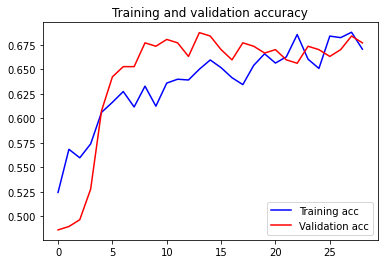

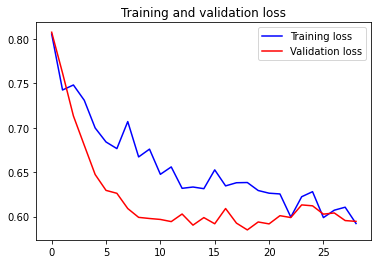

In [19]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [20]:
pneu_model.load_weights(weight_path)
pneu_model.save('full_model.h5')

In [21]:
# concatenate to single array
out_cat_y = np.argmax(np.concatenate(out_y, 0), -1)
pred_cat_y = np.argmax(np.concatenate(pred_y, 0), -1)
pred_conf_y = np.concatenate(pred_y, 0)[:,1]

              precision    recall  f1-score   support

           0       0.49      0.59      0.54        76
           1       0.75      0.67      0.71       140

    accuracy                           0.64       216
   macro avg       0.62      0.63      0.62       216
weighted avg       0.66      0.64      0.65       216



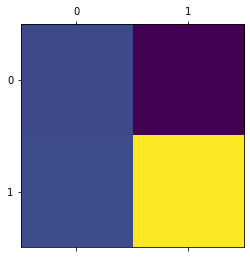

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(out_cat_y, pred_cat_y))
plt.matshow(confusion_matrix(out_cat_y, pred_cat_y))